# Notebook 22: Chapter 6 Figures

This notebook performs a segmentation workflow adapted from NB 11.
The F50 sand experiment F63 is used to generate figures to be used in Chapter
6 of Gus's thesis.

# Import packages

In [12]:
# Standard library imports
from pathlib import Path
# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import signal
from skimage import color, measure
# Local module imports
from segmentflow import segment, view
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load 3D data

Passing `slice_crop`, `row_crop`, and `col_crop` to only load part of the dataset

In [18]:
ums_per_pixel = 13.84

Loading images...
--> Images loaded as 3D array:  (150, 150, 150)
Plotting images: [  0  74 149]


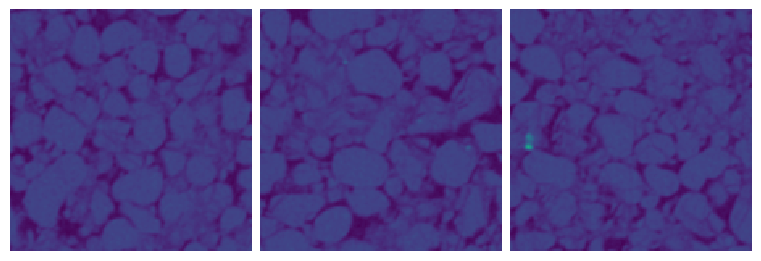

In [2]:
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path('../data/F63tiff/'),
    slice_crop=[400, 550],
    row_crop=[400, 550],
    col_crop=[400, 550],
    convert_to_float=True,
    file_suffix='tiff'
)
slices = np.linspace(0, 149, 3).astype(int)
fig, axes = view.plot_slices(imgs, slices=slices)

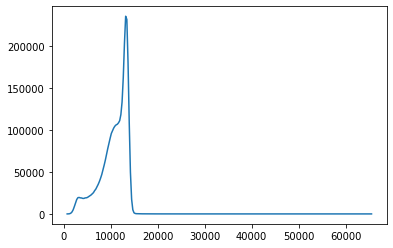

In [3]:
hist, bin_edges = np.histogram(imgs, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

## Preprocess data

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0, 99.9]...
--> Preprocessing complete
Plotting images: [  0  74 149]


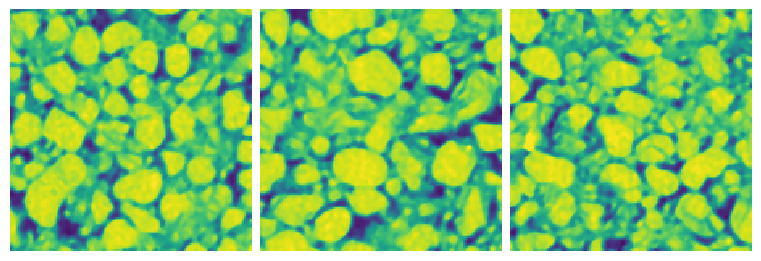

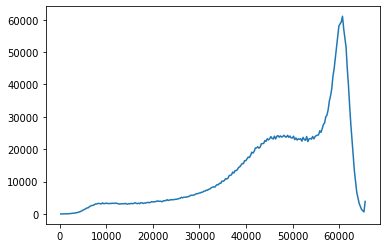

In [4]:
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[0, 99.9]
)
fig, axes = view.plot_slices(imgs_pre, slices=slices)
hist, bin_edges = np.histogram(imgs_pre, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

--> 3 peak(s) found: [11796.300000000001, 47840.55, 59636.85]
--> 2 min(s) found: [12451.65, 51117.3]


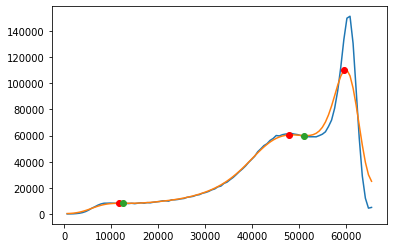

In [5]:
fig, ax = plt.subplots()
nbins = 100
# Calculate histogram
hist, bins = np.histogram(imgs_pre, bins=nbins)
ax.plot(bins[1:], hist)
# Smooth histogram with Gaussian filter
hist_smooth = ndi.gaussian_filter(hist, 3)
ax.plot(bins[1:], hist_smooth, c='C1')
# Find local maxima in smoothed histogram
peak_inds, peak_props = signal.find_peaks(hist_smooth)
peaks = [bins[i] for i in peak_inds]
print(f'--> {len(peaks)} peak(s) found: {peaks}')
for i, val in zip(peak_inds, peaks):
    ax.scatter(val, hist_smooth[i], color='red', zorder=2)
# Find minima between each neighboring pair of local maxima
min_inds = []
for i in range(1, len(peak_inds)):
    min_sub_i = np.argmin(hist_smooth[peak_inds[i - 1] : peak_inds[i]])
    min_inds.append(min_sub_i + peak_inds[i - 1])
mins = [bins[i] for i in min_inds]
print(f'--> {len(mins)} min(s) found: {mins}')
for i, val in zip(min_inds, mins):
    ax.scatter(val, hist_smooth[i], color='C2', zorder=2)
plt.show()

n_vox_binder=1669941
n_vox_grains=1616107
n_vox_nonvoid=3286048
Plotting images: [  0  74 149]


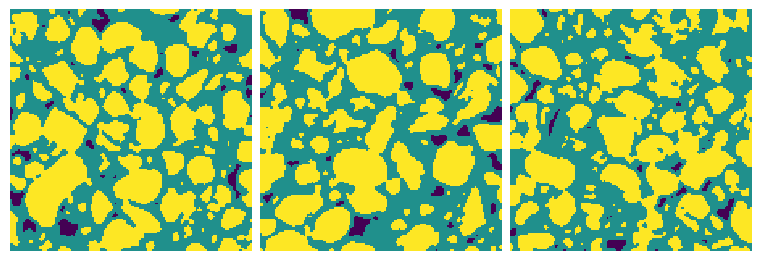

In [19]:
imgs_semantic = segment.isolate_classes(imgs_pre, mins)
n_vox_binder = (imgs_semantic == 1).sum()
print(f'{n_vox_binder=}')
n_vox_grains = (imgs_semantic == 2).sum()
print(f'{n_vox_grains=}')
n_vox_nonvoid = (imgs_semantic > 0).sum()
print(f'{n_vox_nonvoid=}')
fig, axes = view.plot_slices(imgs_semantic, slices=slices)

## Segment Data

Segmenting images...
--> Segmentation complete. 421 particle(s) segmented.


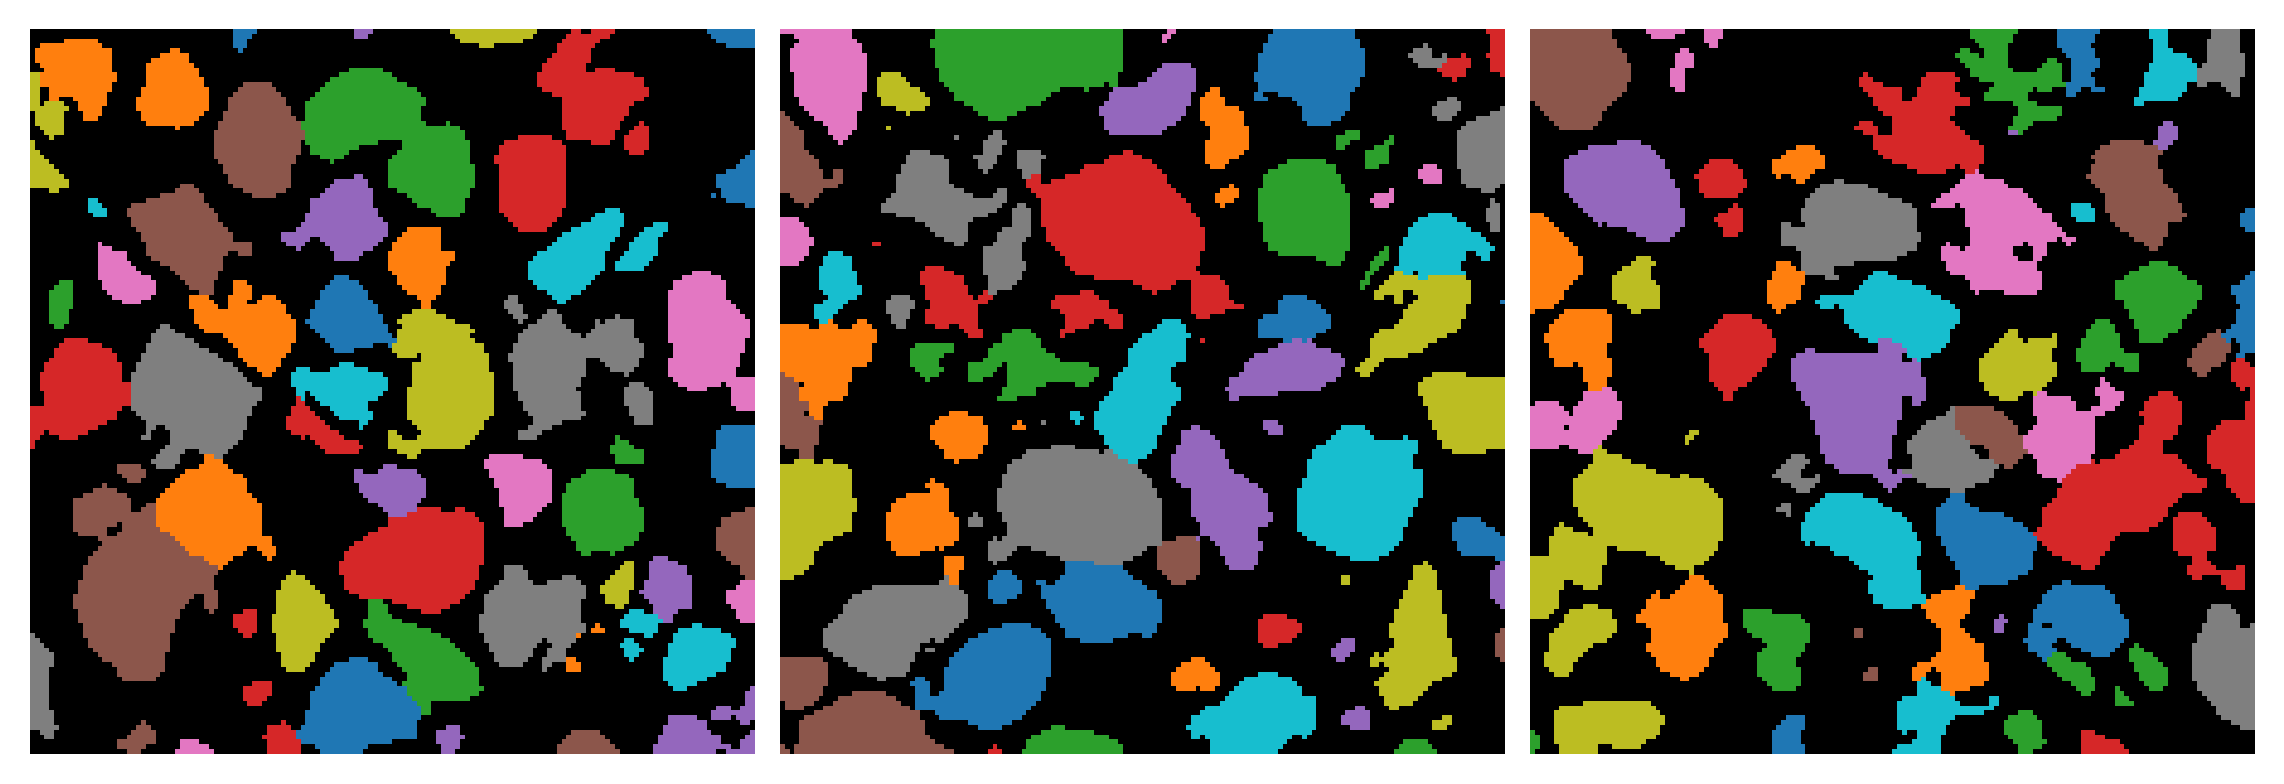

In [117]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=8,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images(labeled_color, dpi=300)

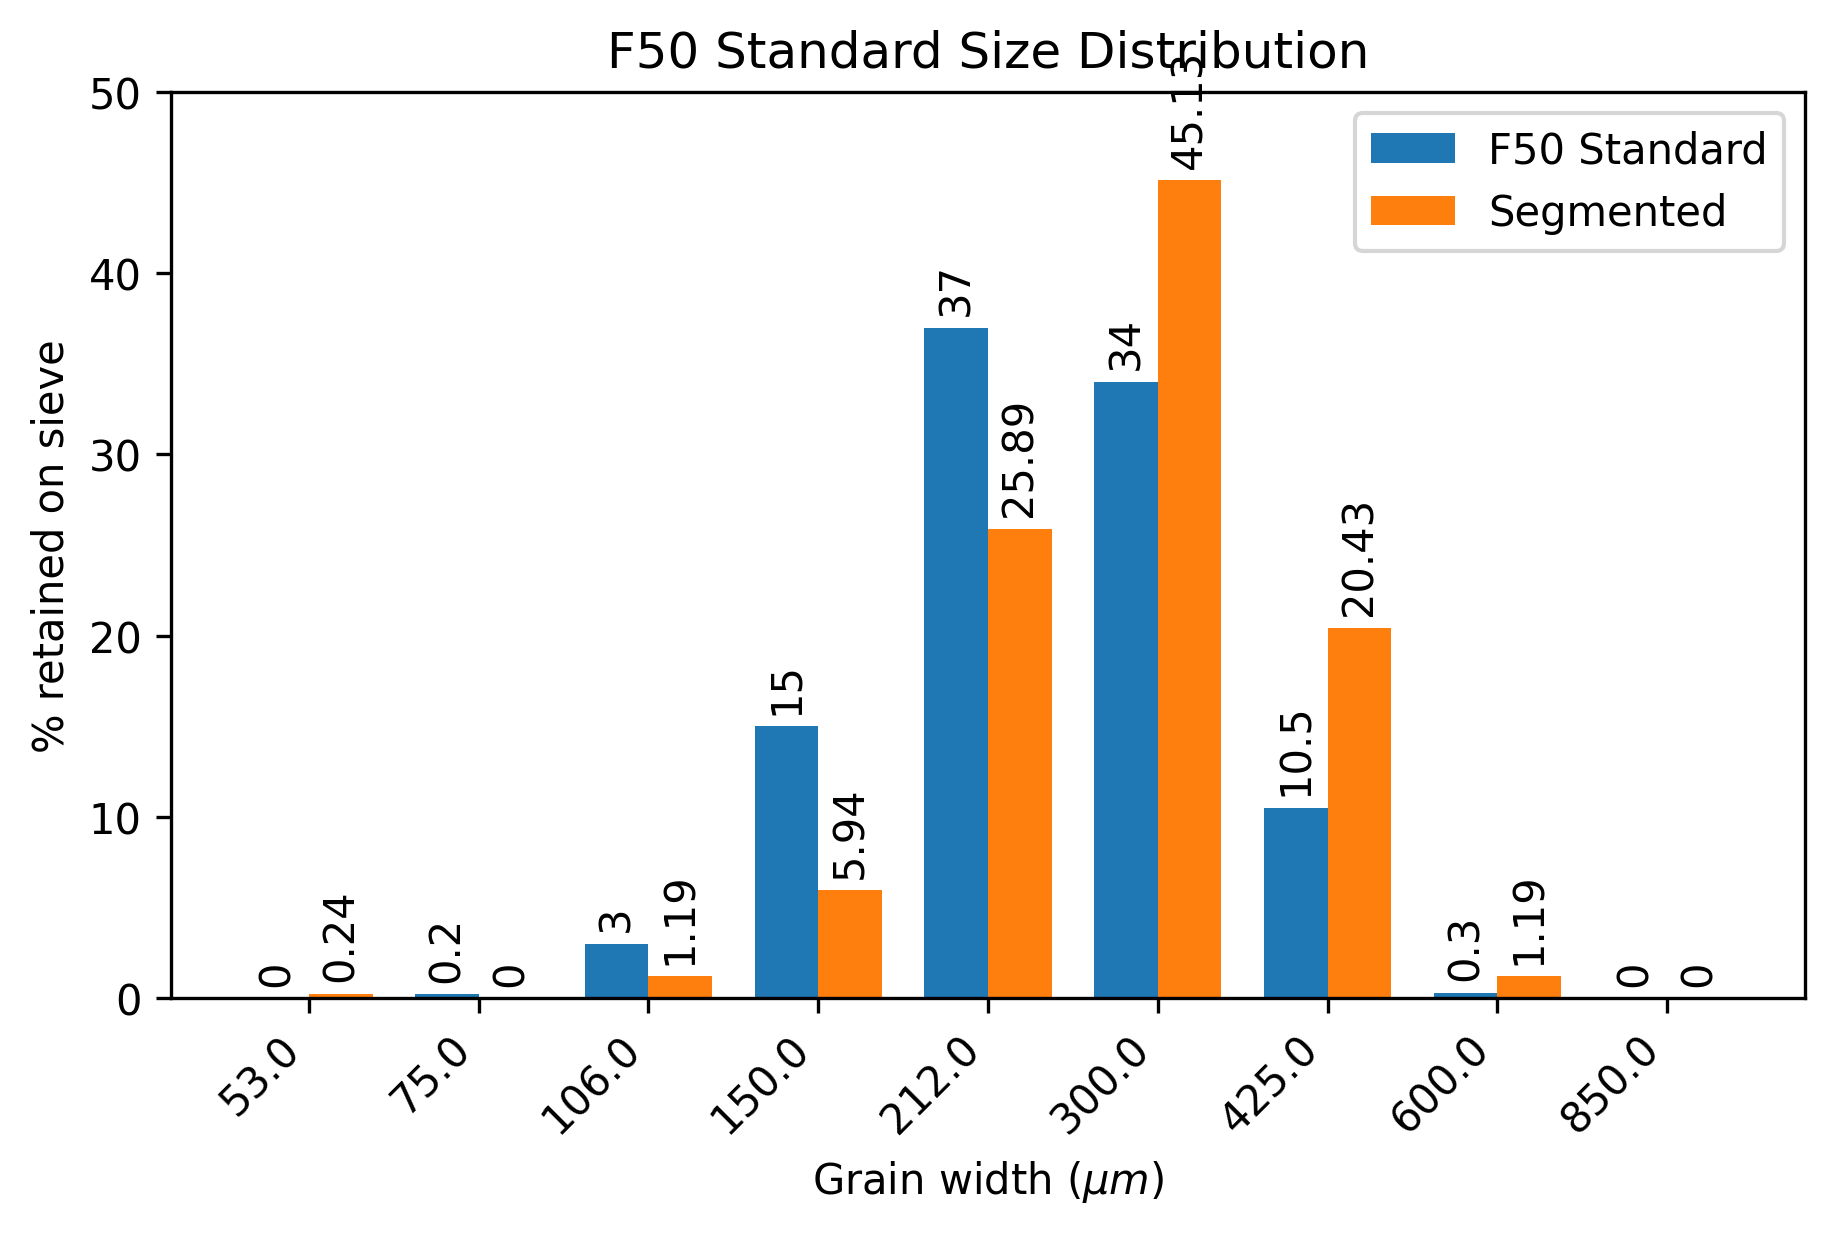

In [118]:
labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
labels_df = labels_df.rename(columns={'area' : 'volume'})
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
ums_area = sieve_df.um.to_numpy()
r = ums_area / 2
ums_vol = 4/3 * np.pi * r**3
# Plot histogram
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
seg_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
seg_pct = 100 * seg_hist / labels_df.shape[0]
x_pos = np.arange(seg_hist.shape[0])  # the label locations
width = 0.75 / 2  # the width of the bars
fig, ax = plt.subplots(constrained_layout=True, dpi=300)
rects_f50 = ax.bar(
        x_pos - width / 2, np.around(f50_pct, 2), width, label='F50 Standard')
rects_seg = ax.bar(
        x_pos + width / 2, np.around(seg_pct, 2), width, label='Segmented')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 50])
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Grain width ($\mu m$)')
ax.legend()
ax.bar_label(rects_f50, padding=3, rotation=90)
ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

### `min_peak_distance` = 7

Segmenting images...
--> Segmentation complete. 520 particle(s) segmented.


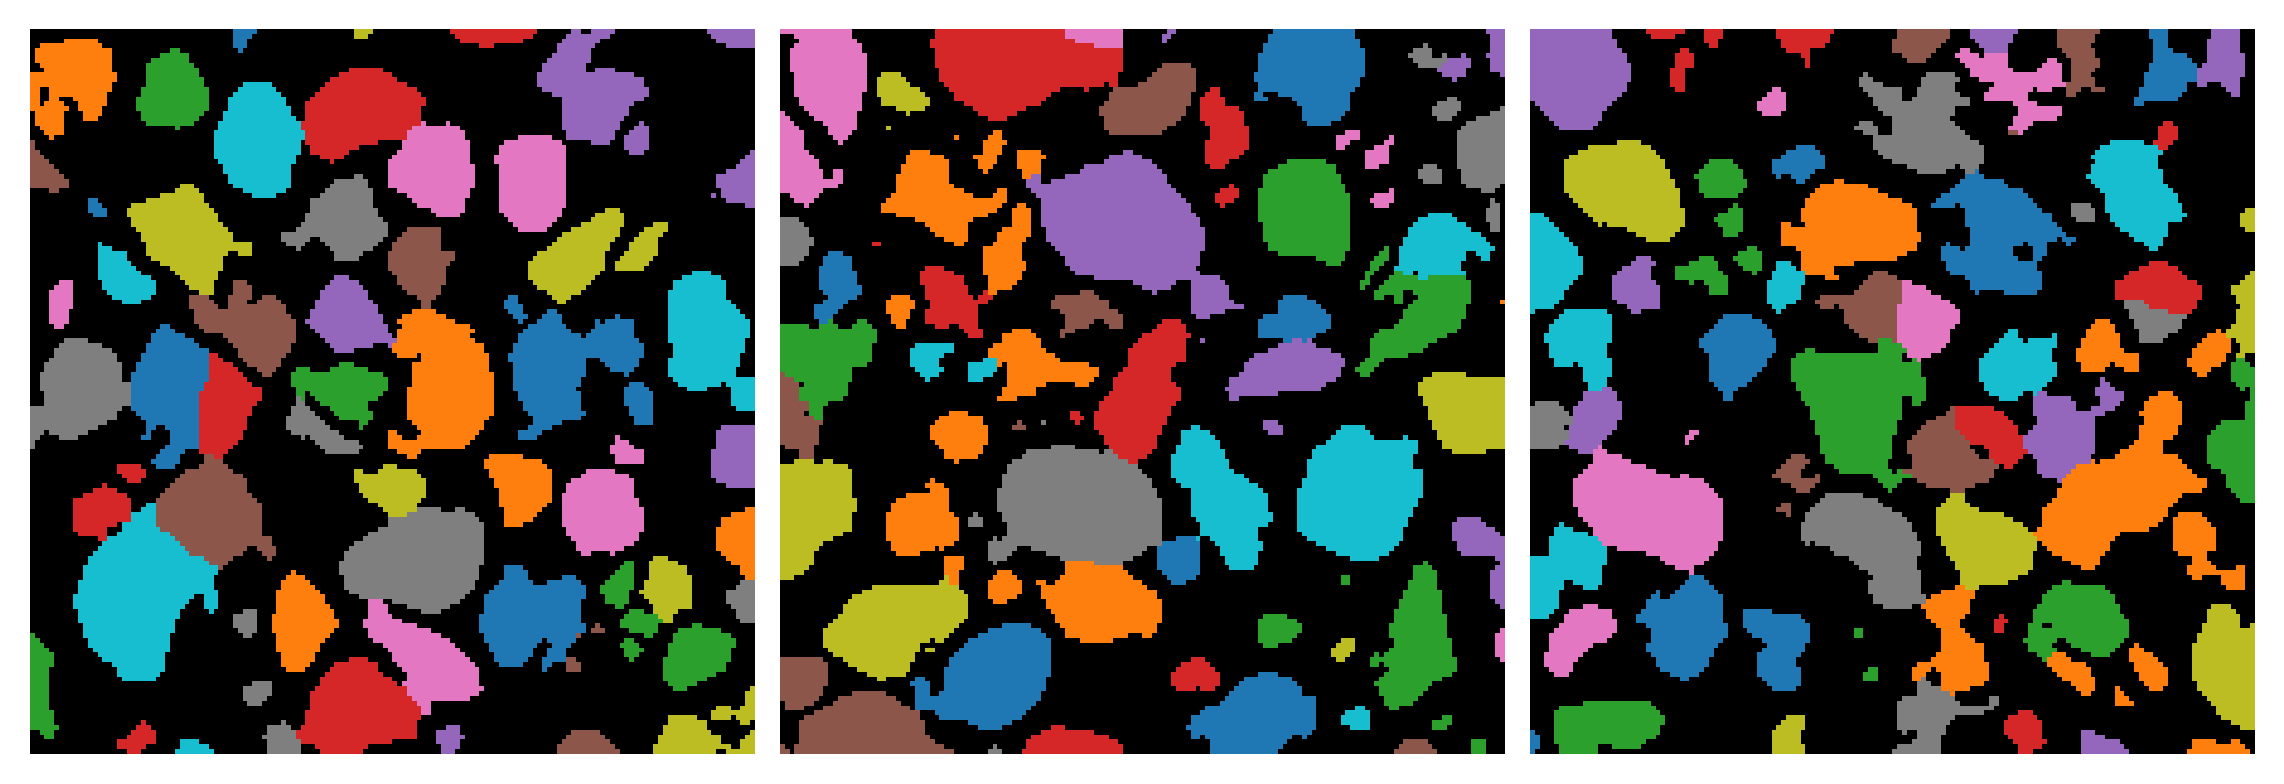

In [109]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=7,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images(labeled_color, dpi=300)

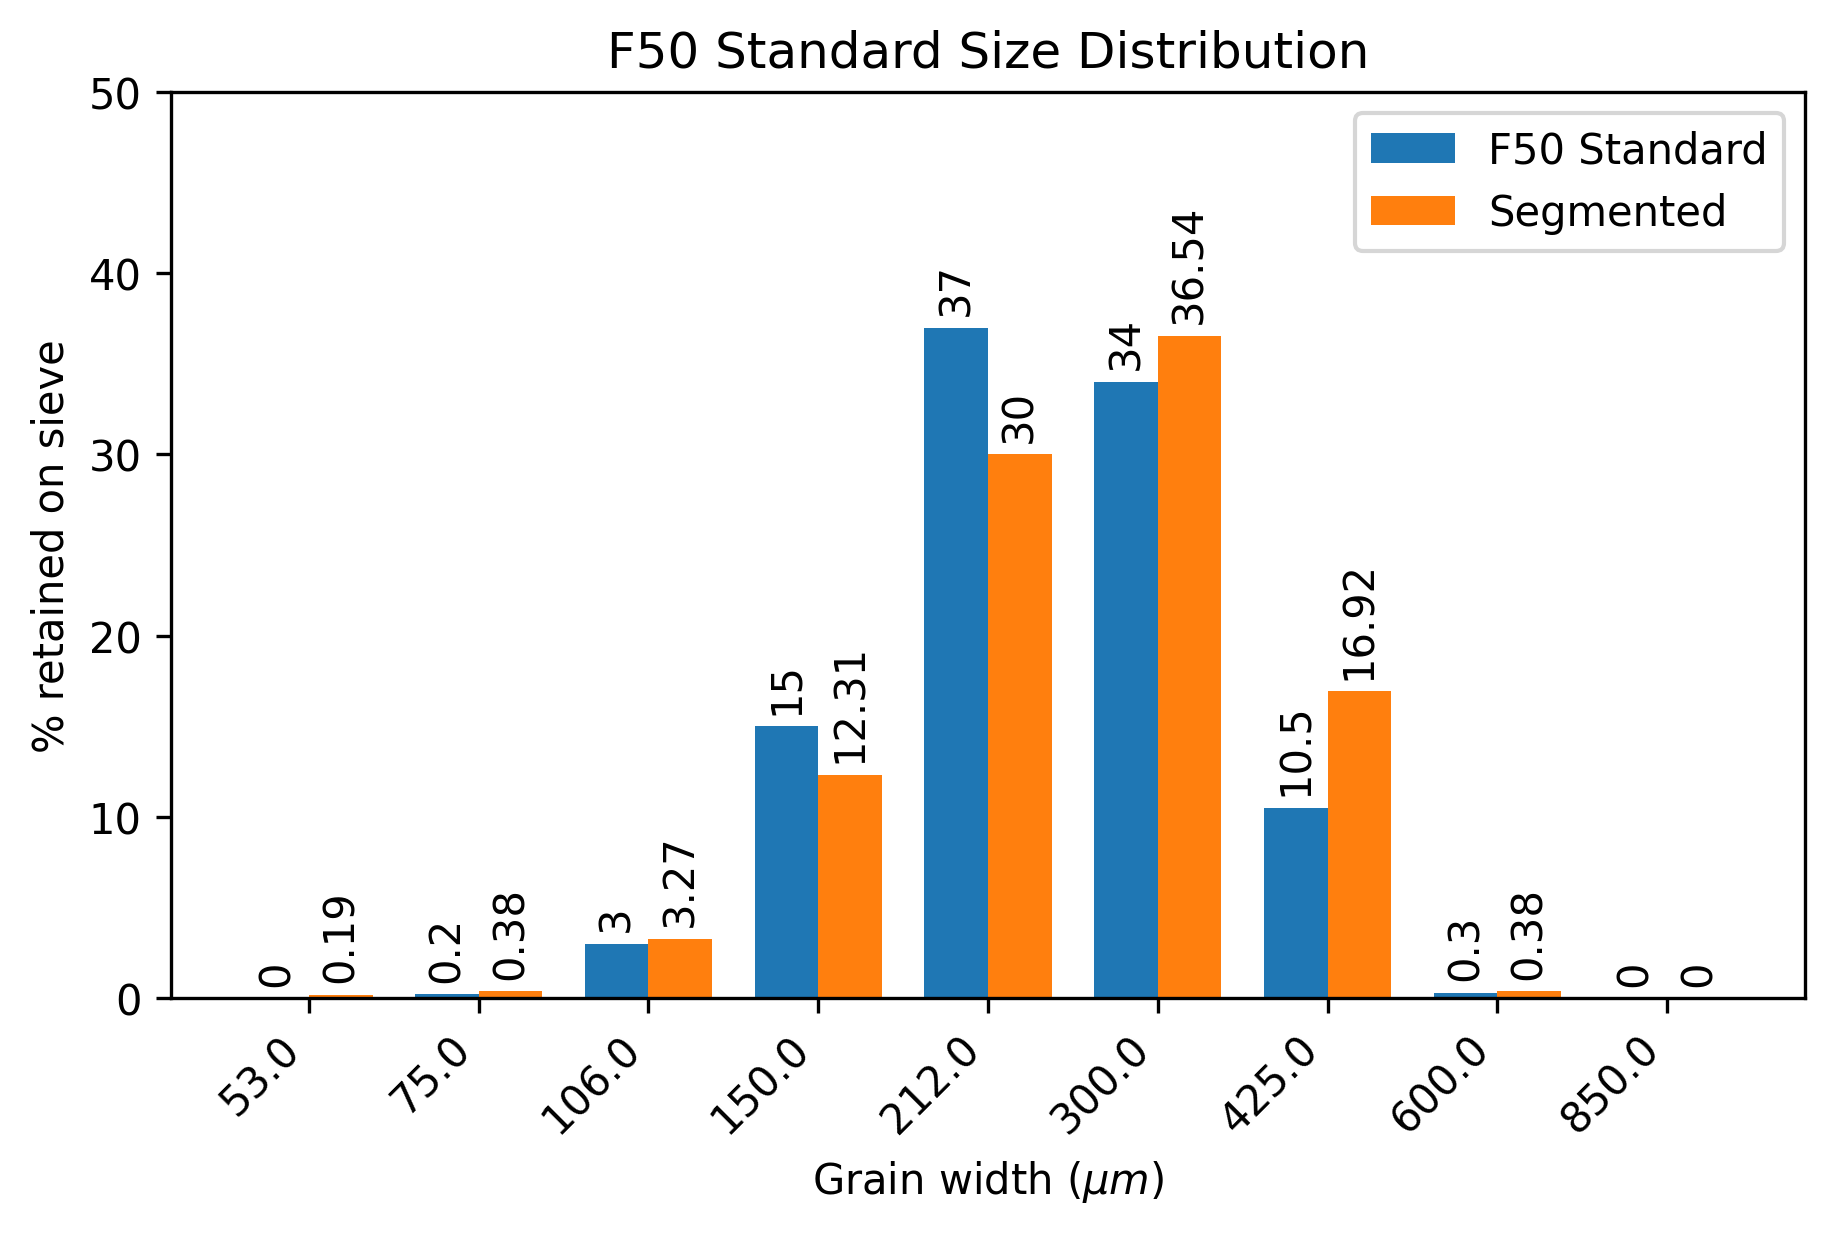

In [110]:
labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
labels_df = labels_df.rename(columns={'area' : 'volume'})
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
ums_area = sieve_df.um.to_numpy()
r = ums_area / 2
ums_vol = 4/3 * np.pi * r**3
# Plot histogram
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
seg_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
seg_pct = 100 * seg_hist / labels_df.shape[0]
x_pos = np.arange(seg_hist.shape[0])  # the label locations
width = 0.75 / 2  # the width of the bars
fig, ax = plt.subplots(constrained_layout=True, dpi=300)
rects_f50 = ax.bar(
        x_pos - width / 2, np.around(f50_pct, 2), width, label='F50 Standard')
rects_seg = ax.bar(
        x_pos + width / 2, np.around(seg_pct, 2), width, label='Segmented')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 50])
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Grain width ($\mu m$)')
ax.legend()
ax.bar_label(rects_f50, padding=3, rotation=90)
ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

Segmenting images...
--> Segmentation complete. 649 particle(s) segmented.


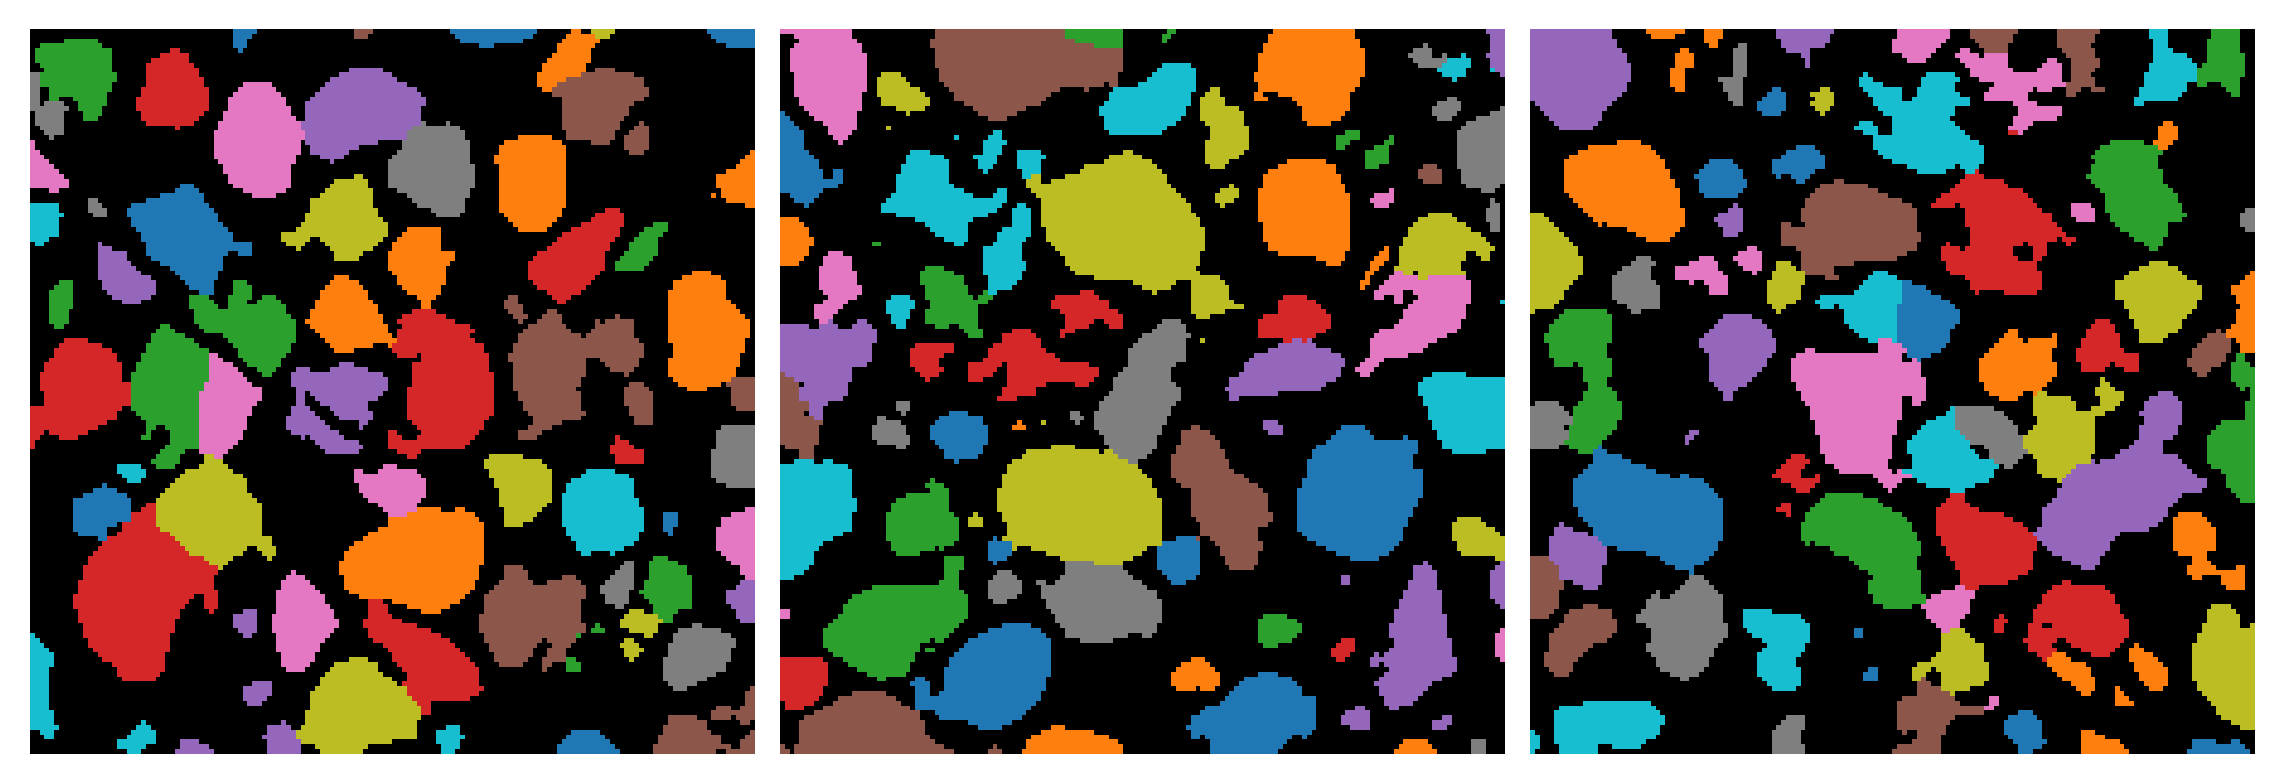

In [119]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=6,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images( labeled_color, dpi=300)

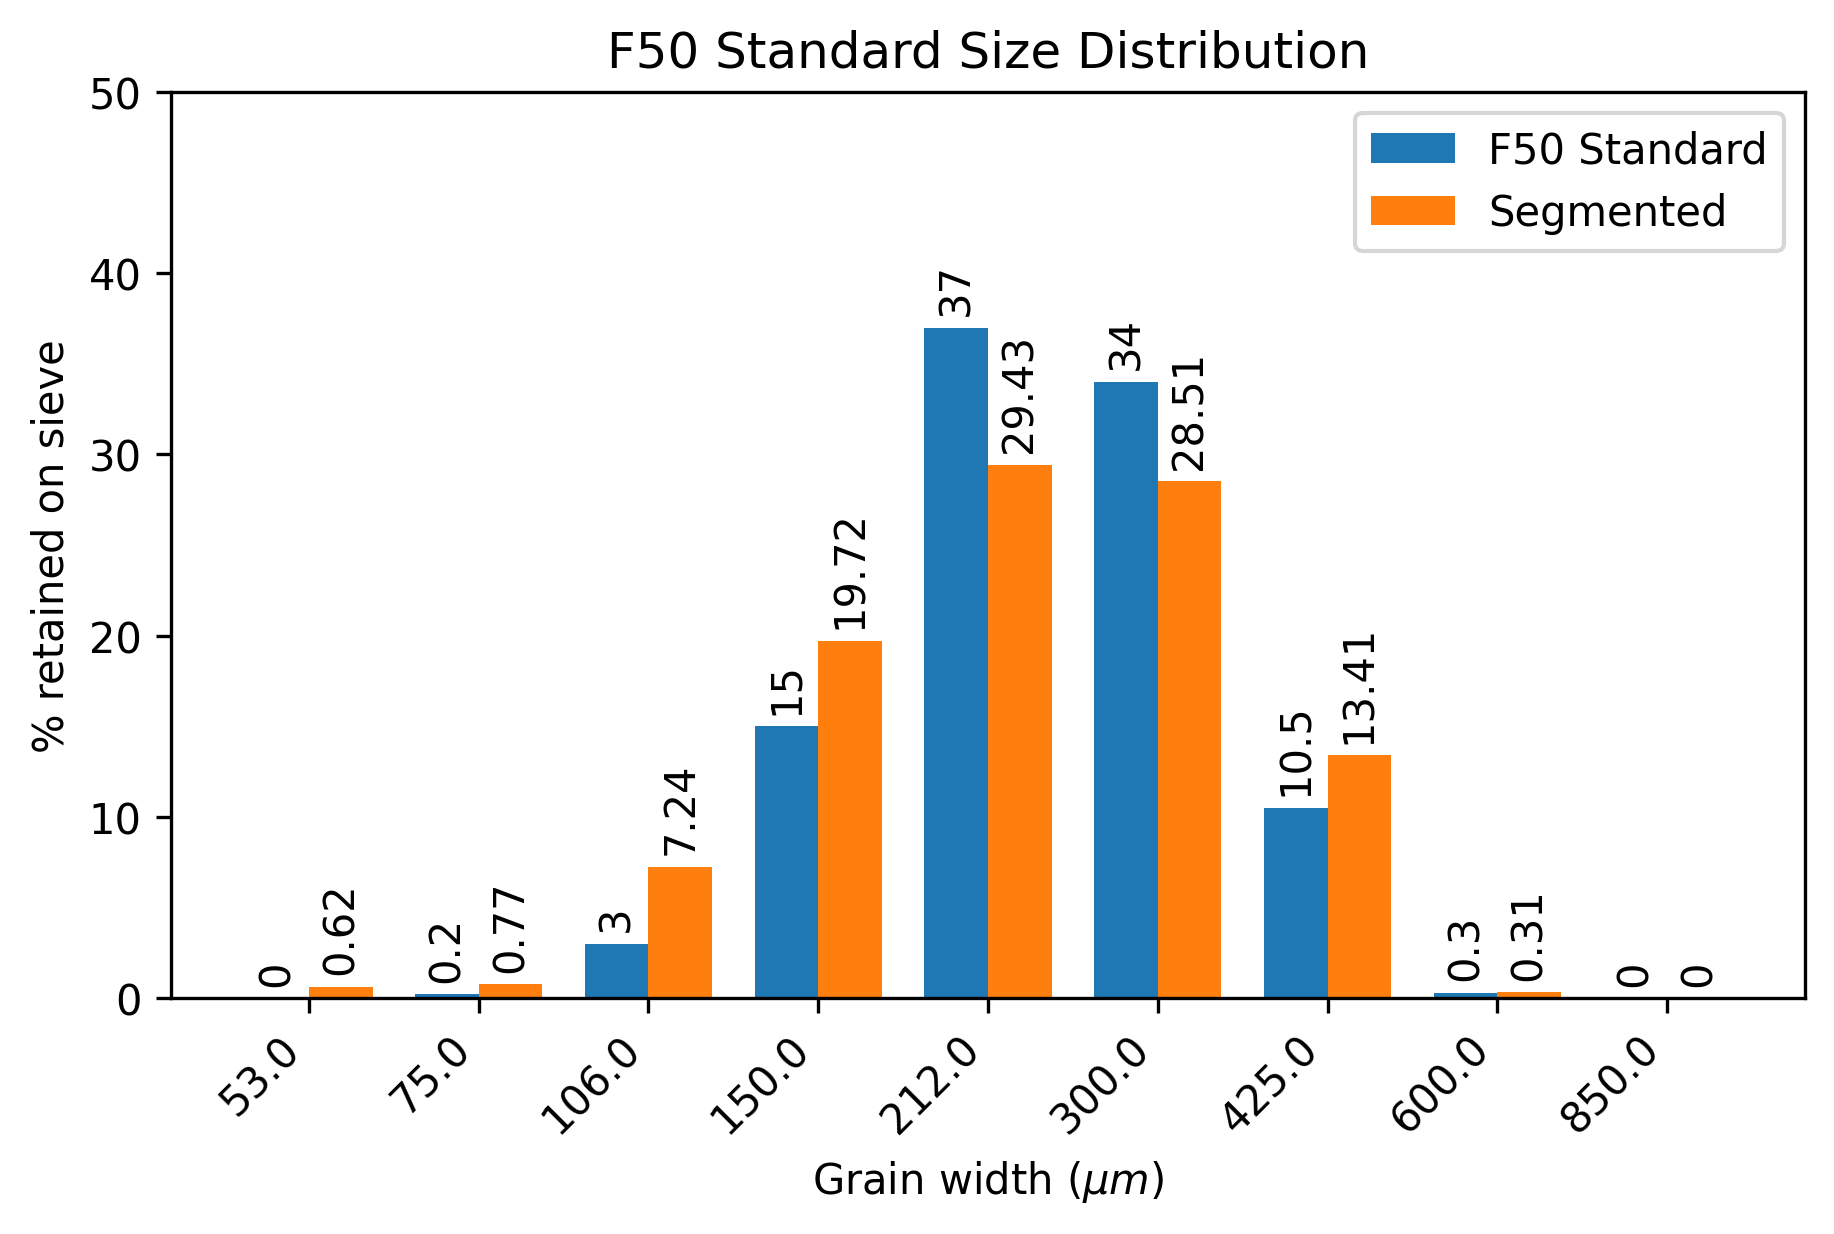

In [120]:
labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
labels_df = labels_df.rename(columns={'area' : 'volume'})
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
r = sieve_df.um.to_numpy() / 2
ums_vol = 4/3 * np.pi * r**3
# Plot histogram
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
seg_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
seg_pct = 100 * seg_hist / labels_df.shape[0]
x_pos = np.arange(seg_hist.shape[0])  # the label locations
width = 0.75 / 2  # the width of the bars
fig, ax = plt.subplots(constrained_layout=True, dpi=300)
rects_f50 = ax.bar(
        x_pos - width / 2, np.around(f50_pct, 2), width, label='F50 Standard')
rects_seg = ax.bar(
        x_pos + width / 2, np.around(seg_pct, 2), width, label='Segmented')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 50])
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Grain width ($\mu m$)')
ax.legend()
ax.bar_label(rects_f50, padding=3, rotation=90)
ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

Segmenting images...
--> Segmentation complete. 878 particle(s) segmented.


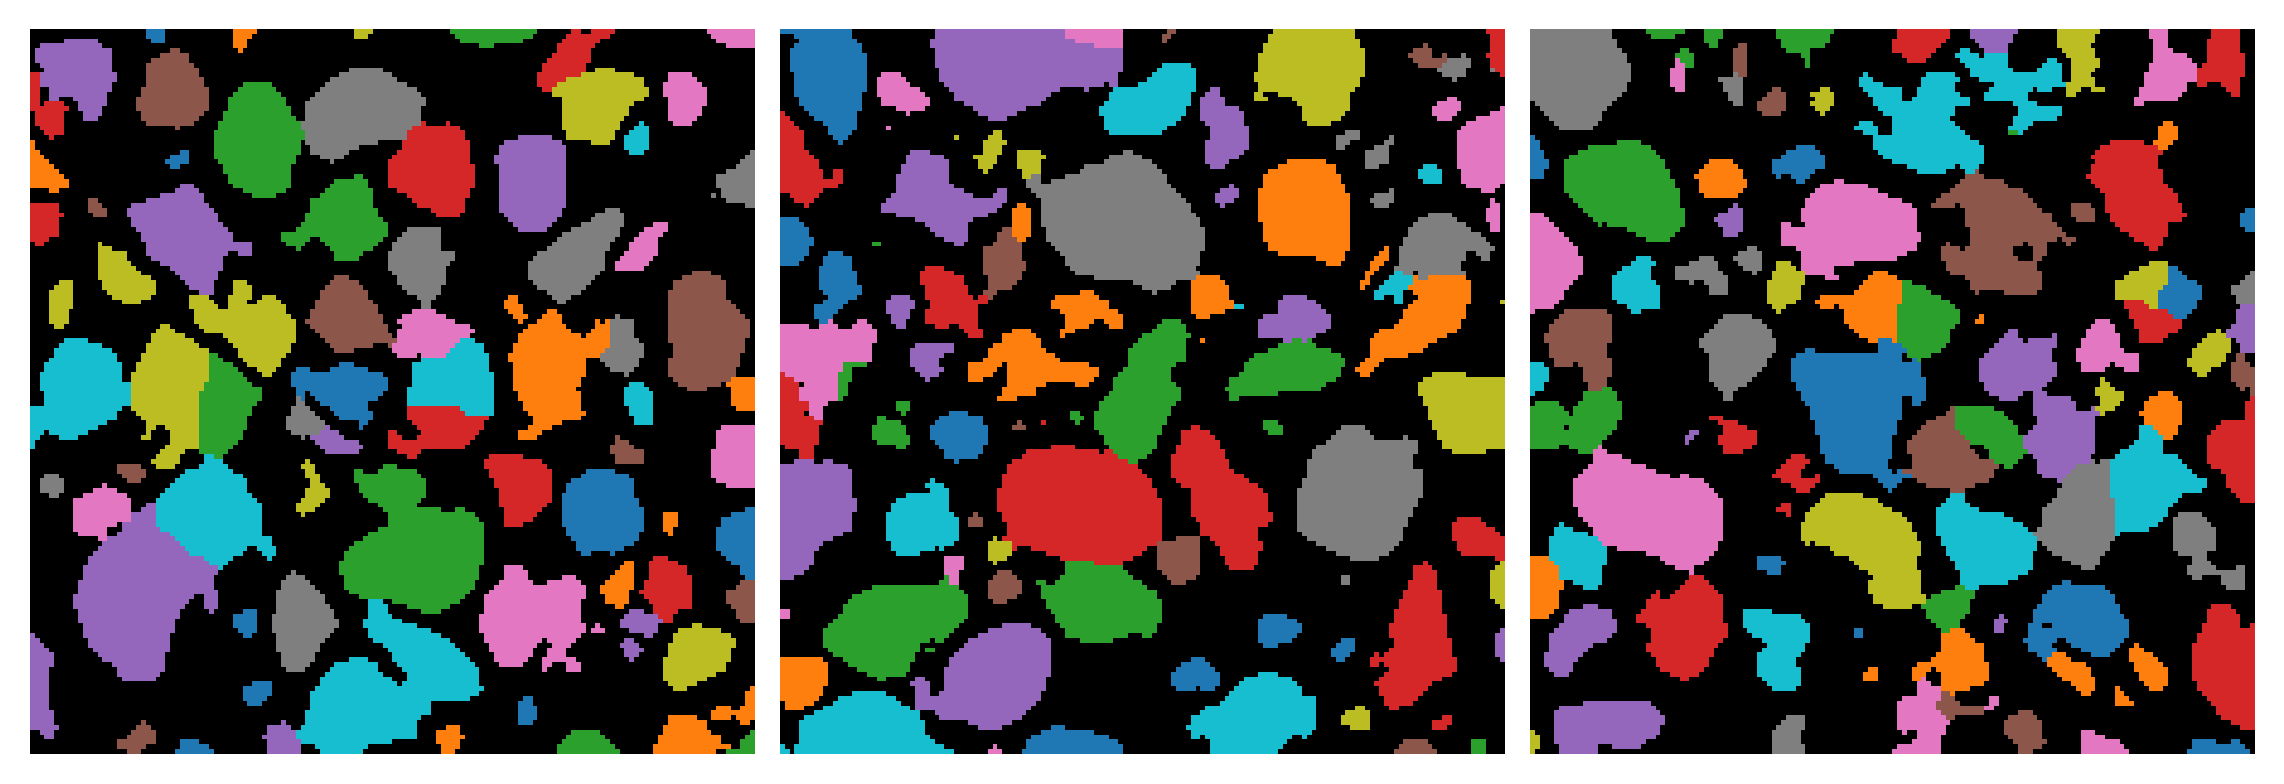

In [111]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=5,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images( labeled_color, dpi=300)

Plotting images: [  0  74 149]


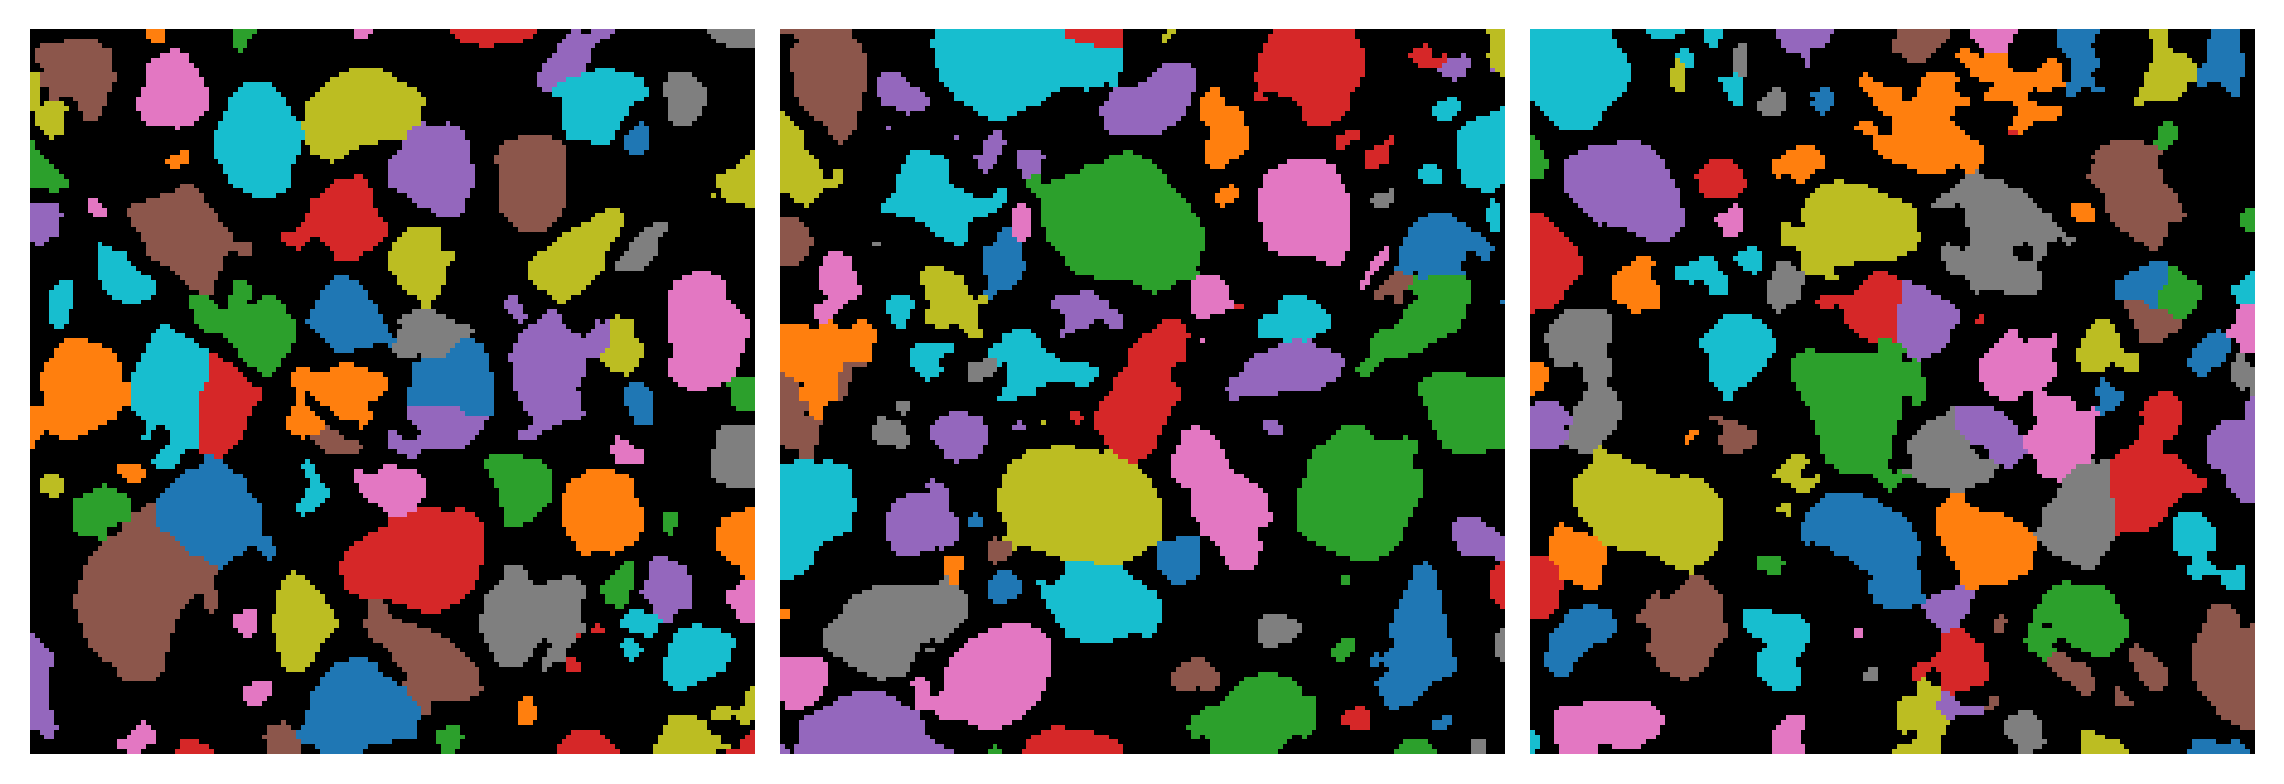

In [ ]:
imgs_labeled_cyclic = np.zeros_like(imgs_labeled)
for i in range(1, imgs_labeled.max() + 1):
    imgs_labeled_cyclic[imgs_labeled == i] = i % 10 + 1
fig, axes = view.plot_slices(
    np.zeros_like(imgs_labeled_cyclic), slices=slices, cmap='gray', dpi=300)
imgs_labeled_cyclic = np.ma.masked_where(
    imgs_labeled_cyclic < 1, imgs_labeled_cyclic)
for i, ax in zip(slices, axes):
    ax.imshow(
        imgs_labeled_cyclic[i, ...], cmap=mpl.cm.tab10,
        interpolation='nearest')

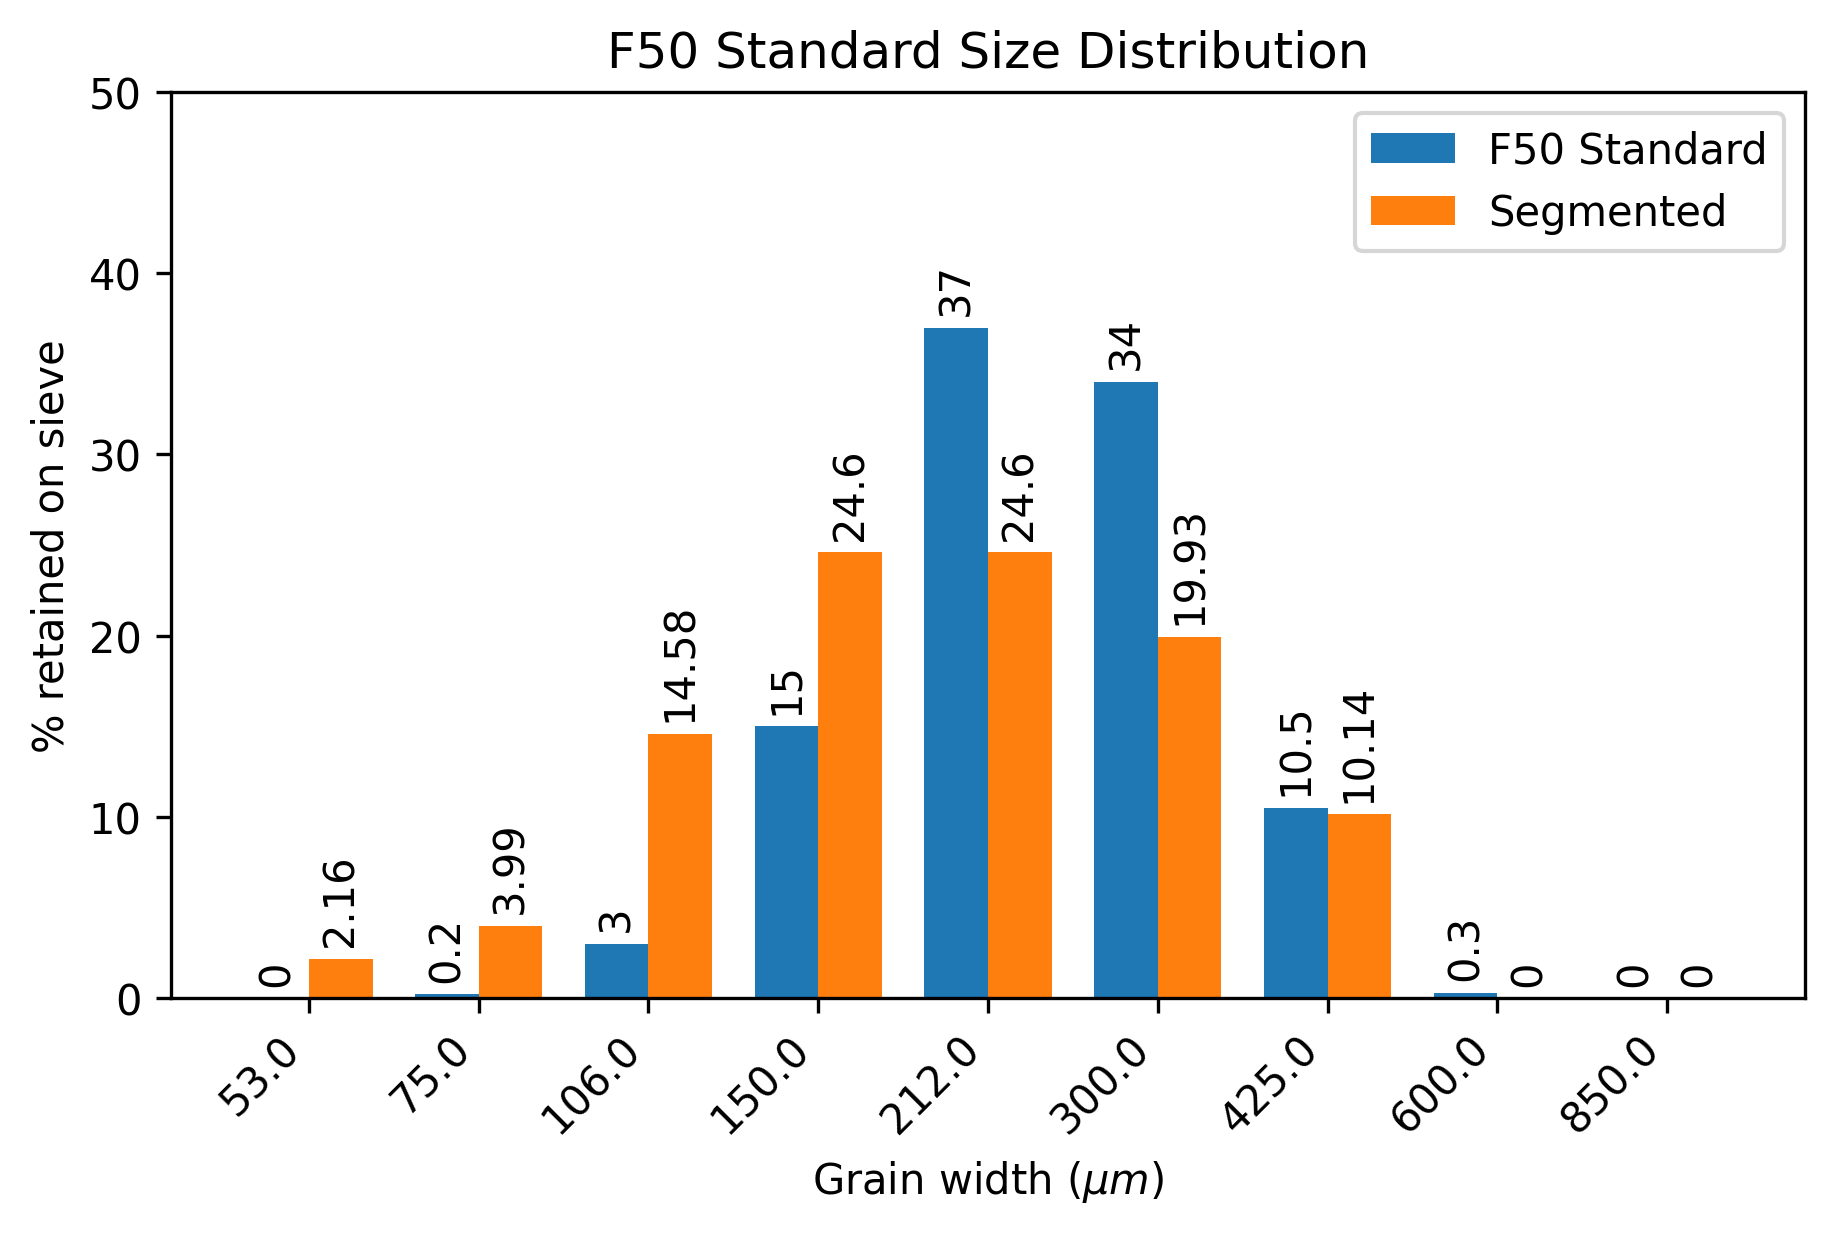

In [112]:
labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
labels_df = labels_df.rename(columns={'area' : 'volume'})
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
r = sieve_df.um.to_numpy() / 2
ums_vol = 4/3 * np.pi * r**3
# Plot histogram
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
seg_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
seg_pct = 100 * seg_hist / labels_df.shape[0]
x_pos = np.arange(seg_hist.shape[0])  # the label locations
width = 0.75 / 2  # the width of the bars
fig, ax = plt.subplots(constrained_layout=True, dpi=300)
rects_f50 = ax.bar(
        x_pos - width / 2, np.around(f50_pct, 2), width, label='F50 Standard')
rects_seg = ax.bar(
        x_pos + width / 2, np.around(seg_pct, 2), width, label='Segmented')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 50])
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Grain width ($\mu m$)')
ax.legend()
ax.bar_label(rects_f50, padding=3, rotation=90)
ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

Segmenting images...
--> Segmentation complete. 1236 particle(s) segmented.


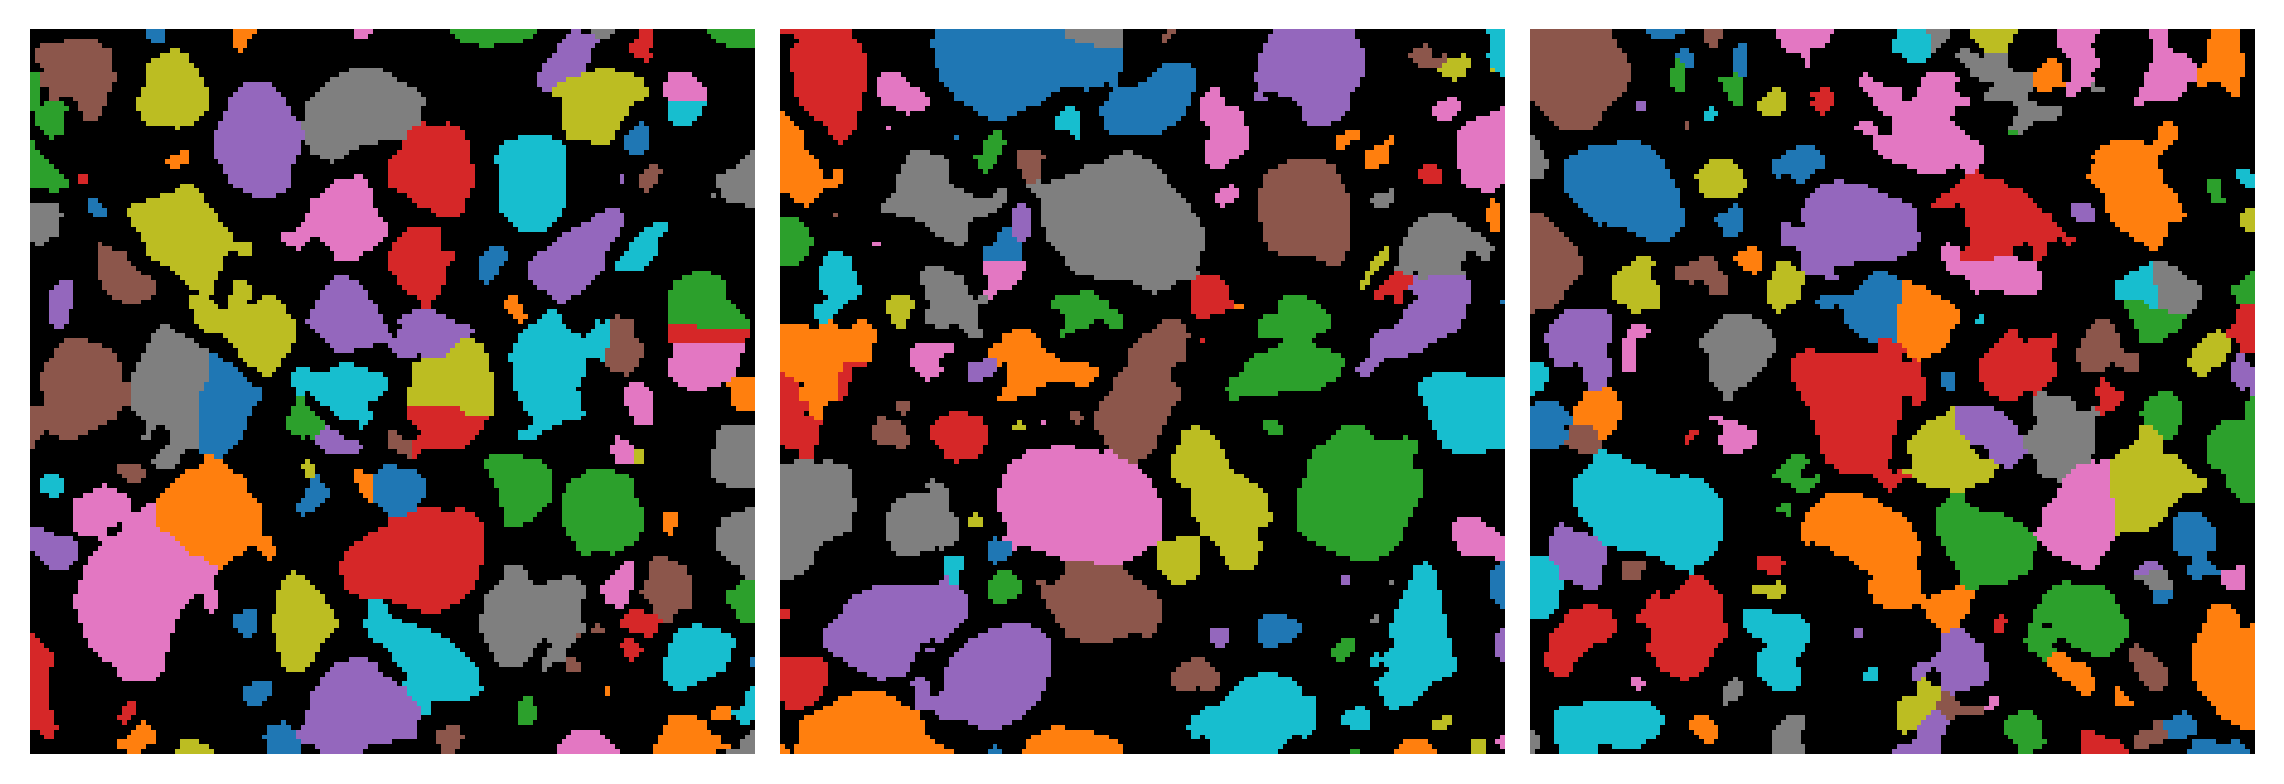

In [115]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=4,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images( labeled_color, dpi=300)

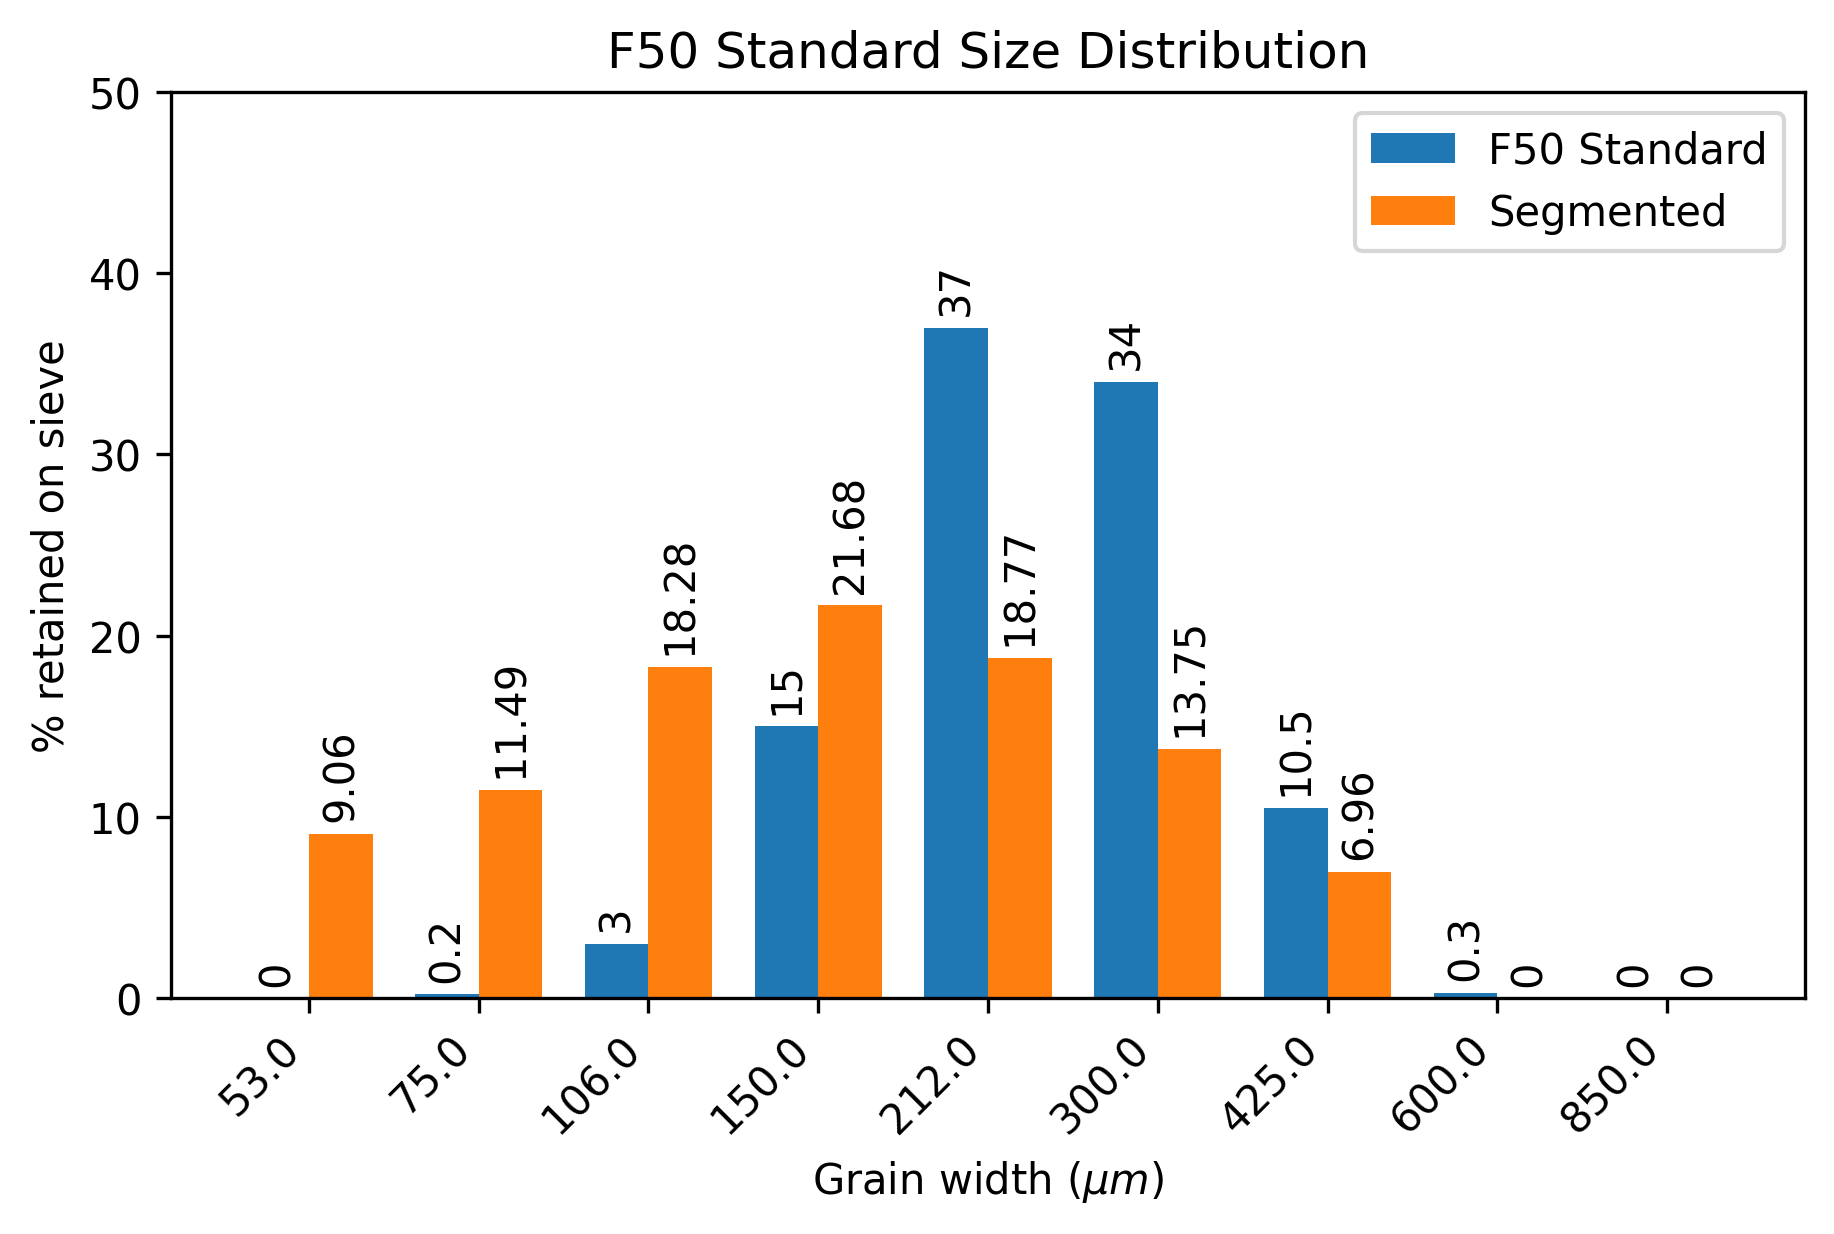

In [116]:
labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
labels_df = labels_df.rename(columns={'area' : 'volume'})
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
r = sieve_df.um.to_numpy() / 2
ums_vol = 4/3 * np.pi * r**3
# Plot histogram
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
seg_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
seg_pct = 100 * seg_hist / labels_df.shape[0]
x_pos = np.arange(seg_hist.shape[0])  # the label locations
width = 0.75 / 2  # the width of the bars
fig, ax = plt.subplots(constrained_layout=True, dpi=300)
rects_f50 = ax.bar(
        x_pos - width / 2, np.around(f50_pct, 2), width, label='F50 Standard')
rects_seg = ax.bar(
        x_pos + width / 2, np.around(seg_pct, 2), width, label='Segmented')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 50])
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Grain width ($\mu m$)')
ax.legend()
ax.bar_label(rects_f50, padding=3, rotation=90)
ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

From here, generate a set of STLs for different values for `min_peak_distance`,
perform a simulated sieve analysis on each dataset, and determine from there
which value achieves the closest calculated fit with the manufacturer's sieve
analysis.

Using volume of equivalent sphere for simulated sieve analysis. Next step will
be to collapse the above plot into a single plot and compare this with
the aspect ratio corrected spheres.